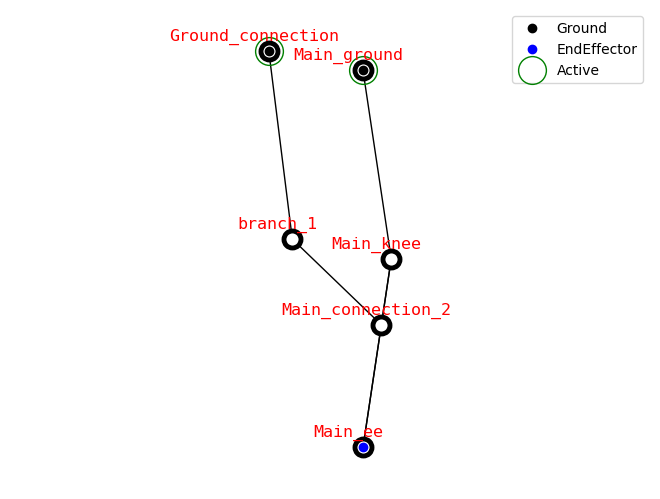

In [1]:
from auto_robot_design.motion_planning.dataset_generator import Dataset, DatasetGenerator

dataset = Dataset("/var/home/yefim-work/Documents/auto-robotics-design/test")

data_gen = DatasetGenerator(dataset.graph_manager, "/var/home/yefim-work/Documents/auto-robotics-design/test2", tuple(dataset.ws_args))

In [2]:
import torch
torch.cuda.is_available()

False

In [3]:
import numpy as np
df = dataset.df
low_bnds = np.array([value[0] for value in dataset.graph_manager.mutation_ranges.values()])[np.newaxis,:]
up_bnds = np.array([value[1] for value in dataset.graph_manager.mutation_ranges.values()])[np.newaxis,:]
# Perform min-max normalization
df_normalized = np.round(2* (df.values[:,:dataset.params_size] - low_bnds) / (up_bnds - low_bnds) - 1,4)
np.round(df_normalized,4).max(0), np.round(df_normalized,4).min(0)

(array([1. , 0.5, 1. , 1. , 1. , 1. , 1. ]),
 array([-1., -1., -1., -1., -1., -1., -1.]))

In [4]:
np.mean(df_normalized, axis=0), np.std(df_normalized, axis=0)

(array([-6.86051952e-02, -3.12293136e-01, -1.62458627e-02, -2.87660076e-03,
        -5.89183288e-04,  2.57593360e-03, -2.59933804e-05]),
 array([0.68952378, 0.53652138, 0.70756637, 0.70761539, 0.7070085 ,
        0.70713913, 0.70710984]))

In [62]:
import pandas as pd

from torch.utils.data import Dataset
from functools import partial

def min_max_normalization(vec, lb, ub):
    return 2* (vec - lb) / (ub - lb) - 1

def reshape_2d(vec_1d, shape):
    return vec_1d.reshape(shape)

class WorkspaceDataset(Dataset):
    def __init__(self, df, parameter_size, workspace_size, param_transform=None, workspace_tranform=None):
        self.df = df
        self.param_size = parameter_size
        self.ws_size = workspace_size
        self.param_trf = param_transform
        self.ws_trf = workspace_tranform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        params = sample.values[:self.param_size]
        ws = sample.values[self.param_size:self.param_size+self.ws_size]
        if self.param_trf:
            params = self.param_trf(params)
        if self.ws_trf:
            ws = self.ws_trf(ws)
        
        params = torch.from_numpy(params).to(torch.float32)
        ws = torch.from_numpy(ws).to(torch.float32)
        
        return params, ws

class TestDatasetWorkspace(Dataset):
    def __init__(self, data_gen, len_test, param_transform=None, workspace_tranform=None) -> None:
        self.data_gen = data_gen
        self.len = len_test
        self.param_trf = param_transform
        self.ws_trf = workspace_tranform
        
        self.temp_df = pd.DataFrame(columns=dataset.df.columns)

    def update(self):
        low_bnds = np.array([value[0] for value in self.data_gen.graph_manager.mutation_ranges.values()])
        up_bnds = np.array([value[1] for value in self.data_gen.graph_manager.mutation_ranges.values()])
        
        jps_batch = np.zeros((self.len, len(low_bnds)))
        for i in range(self.len):
            jps_batch[i,:] = (up_bnds - low_bnds) * np.random.random(len(low_bnds)) + low_bnds
            
        result = self.data_gen._parallel_calculate_batch(jps_batch)

        jps_params = np.zeros((len(result), self.data_gen.params_size))
        ws_flatten = np.zeros((len(result), self.data_gen.ws_grid_size), dtype=bool)
        for m, (jp_prarm, ws) in enumerate(result):
            jps_params[m,:] = jp_prarm
            ws_flatten[m,:] = ws
        self.temp_df = pd.DataFrame(np.hstack([jps_params, ws_flatten]), columns=self.temp_df.columns)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        sample = self.temp_df.iloc[index]
        params = sample.values[:self.data_gen.params_size]
        ws = sample.values[self.data_gen.params_size:self.data_gen.params_size+self.data_gen.ws_grid_size]
        if self.param_trf:
            params = self.param_trf(params)
        if self.ws_trf:
            ws = self.ws_trf(ws)
        
        params = torch.from_numpy(params).to(torch.float32)
        ws = torch.from_numpy(ws).to(torch.float32)
        
        return params, ws


In [63]:
normalization = partial(min_max_normalization, lb=low_bnds, ub=up_bnds)
reshaper = partial(reshape_2d, shape=dataset.dict_ws_args["grid_shape"])

dataset_torch = WorkspaceDataset(df, dataset.params_size, dataset.ws_grid_size, param_transform=normalization)
test_dataset = TestDatasetWorkspace(data_gen, 100, param_transform=normalization)
test_dataset.update()

In [64]:
from torch.utils.data import DataLoader
batch_size = 64
train_dataloader = DataLoader(dataset_torch, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [65]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [122]:
from torch import nn

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork(dataset.params_size, dataset.ws_grid_size).to(device, non_blocking=True)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=144, bias=True)
    (5): Sigmoid()
  )
)


In [123]:
learning_rate = 5e-4
epochs = 10

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [121]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        
        # X.at_(-1e-4)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct, false = 0, 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred[pred <= 0.5] = 0
            pred[pred > 0.5] = 1
            correct += ((~torch.logical_xor(y.type(torch.bool), pred.type(torch.bool))).sum(1) == y.shape[1]).type(torch.float).sum().item()
            false += y.shape[0] - correct
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n") 

In [124]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.250230  [   64/57707]
loss: 0.113173  [ 6464/57707]
loss: 0.058948  [12864/57707]
loss: 0.048306  [19264/57707]
loss: 0.079132  [25664/57707]
loss: 0.038579  [32064/57707]
loss: 0.023153  [38464/57707]
loss: 0.029325  [44864/57707]
loss: 0.029405  [51264/57707]
loss: 0.032276  [57664/57707]
Test Error: 
 Accuracy: 49.0%, Avg loss: 0.031867 

Epoch 2
-------------------------------
loss: 0.033369  [   64/57707]
loss: 0.014233  [ 6464/57707]
loss: 0.023322  [12864/57707]
loss: 0.031232  [19264/57707]
loss: 0.021052  [25664/57707]
loss: 0.045101  [32064/57707]
loss: 0.049385  [38464/57707]
loss: 0.013272  [44864/57707]
loss: 0.029590  [51264/57707]
loss: 0.035369  [57664/57707]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.022779 

Epoch 3
-------------------------------
loss: 0.023227  [   64/57707]
loss: 0.021709  [ 6464/57707]
loss: 0.044586  [12864/57707]
loss: 0.023011  [19264/57707]
loss: 0.021133  [25664/57707]
loss: 0.023064  [32064/577

In [3]:
import numpy as np
from auto_robot_design.description.builder import ParametrizedBuilder, URDFLinkCreater3DConstraints, jps_graph2pinocchio_robot_3d_constraints, MIT_CHEETAH_PARAMS_DICT
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(URDFLinkCreater3DConstraints,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

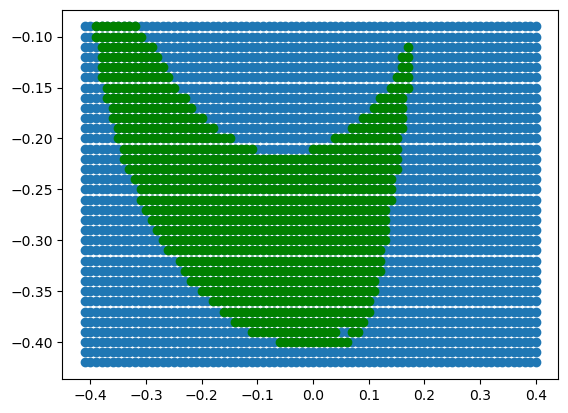

In [4]:
import matplotlib.pyplot as plt

reachable_pts = ws.reachable_points
pts = ws.points

plt.plot(reachable_pts[:,0],reachable_pts[:,1], "og")
plt.scatter(pts[:,0],pts[:,1])

In [5]:
import numpy as np
from auto_robot_design.user_interface.check_in_ellips import (
    Ellipse,
    check_points_in_ellips
)

ellipse = Ellipse(np.array([0.04,-0.31]), 0, np.array([0.04, 0.01]))
points_on_ellps = ellipse.get_points(0.1).T

reach_ws_points = ws.points
mask_ws_n_ellps = check_points_in_ellips(reach_ws_points, ellipse, 0.1)

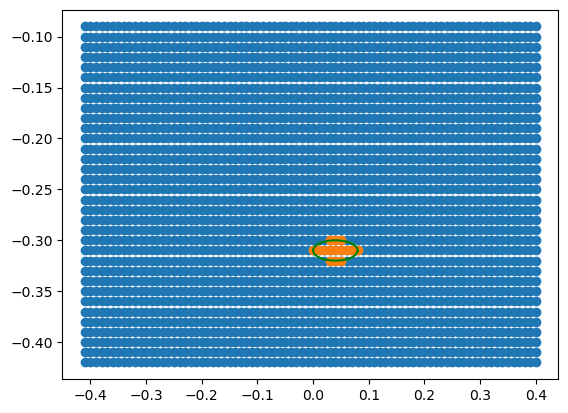

In [6]:
plt.plot(points_on_ellps[:,0], points_on_ellps[:,1], "g")
plt.scatter(pts[:,0],pts[:,1])
plt.scatter(reach_ws_points[mask_ws_n_ellps,:][:,0],reach_ws_points[mask_ws_n_ellps,:][:,1])

In [7]:
ellips_mask = np.zeros(ws.mask_shape, dtype=bool)
for point in reach_ws_points[mask_ws_n_ellps, :]:
    index = ws.calc_index(point)
    ellips_mask[tuple(index)] = True

In [8]:
ws_bool_flatten = np.asarray(dataset.df.values[:,dataset.params_size:], dtype=bool)
ell_mask_2d = ellips_mask.flatten()[np.newaxis :]
np.argwhere(np.sum(ell_mask_2d * ws_bool_flatten, axis=1) ==15).size

26230

In [9]:
dataset.get_all_design_indexes_cover_ellipse(ellipse).size

26230

In [10]:
dataset.df

,jp_0,jp_1,jp_2,jp_3,jp_4,jp_5,jp_6,jp_7,jp_8,jp_9,...,ws_2778,ws_2779,ws_2780,ws_2781,ws_2782,ws_2783,ws_2784,ws_2785,ws_2786,ws_2787
0,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.2,-0.029,-0.3,-0.2,-0.6,-0.2,-0.3,-0.15,0.08,-0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63475,-0.2,-0.029,-0.2,-0.2,-0.6,0.2,-0.3,-0.15,0.08,-0.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63476,-0.2,-0.029,-0.2,-0.2,-0.6,0.2,-0.3,-0.15,0.08,-0.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63477,-0.2,-0.029,-0.2,-0.2,-0.6,0.2,-0.3,-0.15,0.08,-0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63478,-0.2,-0.029,-0.2,-0.2,-0.6,0.2,-0.3,-0.15,0.08,-0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_upd = dataset.df.assign(total_ws = lambda x: np.sum(x.values[:,dataset.params_size:],axis=1)/dataset.ws_grid_size)
# df_upd["total_ws"] = dens_ws_by_design

df_upd = df_upd[df_upd["total_ws"] > 100/dataset.ws_grid_size]
df_upd = df_upd.sort_values(["total_ws"], ascending=False)
df_upd

,jp_0,jp_1,jp_2,jp_3,jp_4,jp_5,jp_6,jp_7,jp_8,jp_9,...,ws_2779,ws_2780,ws_2781,ws_2782,ws_2783,ws_2784,ws_2785,ws_2786,ws_2787,total_ws
60123,-0.2,-0.029,-0.2,-0.2,-0.6,-0.2,0.15,-0.085,0.14,-0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.674319
59718,-0.2,-0.029,-0.2,-0.2,-0.6,-0.2,-0.30,-0.020,0.20,-0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673960
60204,-0.2,-0.029,-0.2,-0.2,-0.6,-0.2,0.15,-0.085,0.20,-0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673960
62634,-0.2,-0.029,-0.2,-0.2,-0.6,0.0,0.15,-0.020,0.20,-0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673242
59745,-0.2,-0.029,-0.2,-0.2,-0.6,-0.2,-0.30,-0.020,0.20,-0.06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40400,-0.2,-0.029,-0.3,0.2,-0.6,-0.2,0.15,-0.085,0.08,-0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036227
32646,-0.2,-0.029,-0.3,0.0,-0.1,0.2,0.60,-0.020,0.14,-0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036227
54514,-0.2,-0.029,-0.3,0.2,0.4,-0.2,0.60,-0.020,0.14,-0.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036227
32052,-0.2,-0.029,-0.3,0.0,-0.1,0.2,0.15,-0.020,0.20,-0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036227


In [12]:
sort_dataset = np.array(sorted(dataset.df.values, key=lambda x: np.sum(x[dataset.params_size:]), reverse=True))

In [13]:
best_mask_ws = np.array(sort_dataset[0,dataset.params_size:], dtype=bool)
for id_design in np.arange(-100, 100):
    equal_ws = np.sum(best_mask_ws * np.array(sort_dataset[id_design,dataset.params_size:], dtype=bool))
    # param_distance = np.linalg.norm(sort_dataset[id_design,:dataset.params_size] - sort_dataset[0,:dataset.params_size], ord=np.inf)
    param_distance = np.sum(np.abs(sort_dataset[id_design,:dataset.params_size] - sort_dataset[0,:dataset.params_size]))
    print(param_distance, "--", equal_ws)

1.0650000000000002 -- 1
0.7900000000000001 -- 1
0.865 -- 1
0.9650000000000001 -- 1
1.065 -- 1
1.1250000000000002 -- 1
0.9500000000000002 -- 1
1.05 -- 1
0.925 -- 1
1.0250000000000001 -- 1
1.125 -- 1
1.0250000000000001 -- 1
0.9500000000000002 -- 1
0.925 -- 1
0.9250000000000003 -- 1
0.8250000000000002 -- 1
1.1650000000000003 -- 1
0.9900000000000002 -- 1
1.09 -- 1
0.9650000000000001 -- 1
1.0650000000000002 -- 1
1.0650000000000002 -- 1
0.9900000000000002 -- 1
0.9650000000000001 -- 1
0.9650000000000003 -- 1
0.8650000000000002 -- 1
1.2050000000000003 -- 1
1.1300000000000001 -- 1
1.1050000000000002 -- 1
1.1050000000000002 -- 1
1.0050000000000001 -- 1
1.0050000000000001 -- 1
0.9300000000000002 -- 1
0.905 -- 1
1.11 -- 1
0.9850000000000001 -- 1
1.0850000000000002 -- 1
1.0100000000000002 -- 1
0.9850000000000001 -- 1
0.9850000000000003 -- 1
1.1500000000000001 -- 1
1.1250000000000002 -- 1
1.0500000000000003 -- 1
1.0250000000000001 -- 1
1.0250000000000004 -- 1
1.1900000000000002 -- 1
1.16500000000000

0.09708243919473807
1869.0


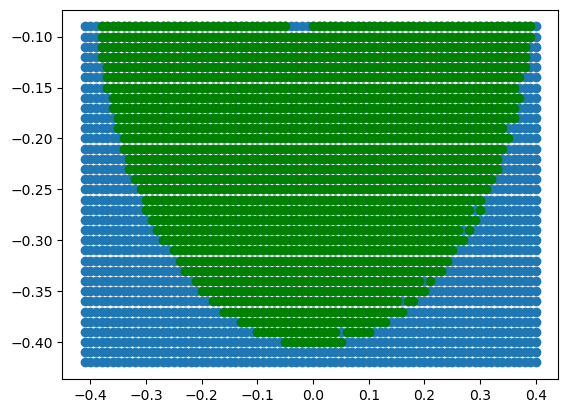

In [14]:
import pandas as pd

id_design = 15
print(np.linalg.norm(sort_dataset[id_design,:dataset.params_size] - sort_dataset[0,:dataset.params_size]))
print(np.sum(sort_dataset[id_design,dataset.params_size:]))
ws_test = dataset.get_workspace_by_sample(pd.Series(sort_dataset[id_design]))
reachable_pts = ws_test.reachable_points
pts = ws_test.points

plt.plot(reachable_pts[:,0],reachable_pts[:,1], "og")
plt.scatter(pts[:,0],pts[:,1])

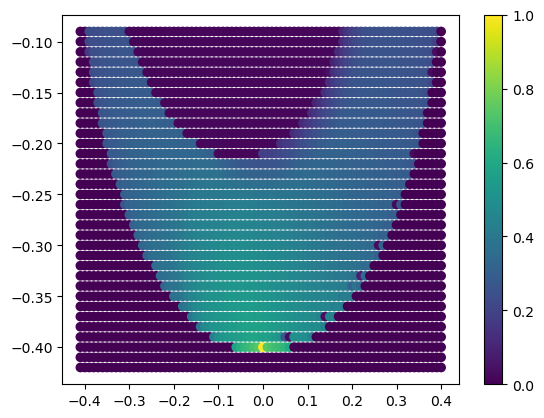

In [15]:
pts = dataset.workspace.points
dens_ws_by_design = np.sum(dataset.df.values[:,dataset.params_size:],axis=0)/dataset.df.shape[0]
plt.scatter(pts[:,0], pts[:,1],c=dens_ws_by_design)
plt.colorbar()

In [16]:
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory


gm = dataset.graph_manager
des_point = np.array([-0.1, -0.35])
traj = np.array(add_auxilary_points_to_trajectory(([des_point[0]], [des_point[1]]))).T
ws_test.check_points_in_ws(traj)


True

In [17]:
from auto_robot_design.motion_planning.trajectory_ik_manager import TrajectoryIKManager
from auto_robot_design.vizualization.meshcat_utils import create_meshcat_vizualizer
fixed_robot = ws_test.robot
traj_6d = fixed_robot.motion_space.get_6d_traj(traj)
ik_manager = TrajectoryIKManager()
ik_manager.register_model(fixed_robot.model, fixed_robot.constraint_models)
ik_manager.set_solver("Closed_Loop_PI")
poses, q_fixed, constraint_errors,reach_array = ik_manager.follow_trajectory(traj_6d)

In [18]:
df_upd["acc_cap"] = np.zeros(df_upd.shape[0])
df_upd["heavy_lift"] = np.zeros(df_upd.shape[0])
df_upd["total_criteria"] = np.zeros(df_upd.shape[0])

In [19]:

from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.optimization.rewards.reward_base import  RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability

import time

from concurrent.futures import ProcessPoolExecutor

dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")


reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(traj_6d, 0)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(heavy_lifting, 0, 1)
total_time = 0

def cacl_criteria(id_design):
    start = time.perf_counter()
    des = df_upd.loc[id_design]
    jp_pos = des.values[:dataset.params_size].round(4)
    graph = gm.get_graph(jp_pos)
    fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(
        graph, builder)
    reward_manager.precalculated_trajectories = None
    __, partial_rewards, vector_rewards = reward_manager.calculate_total(
        fixed_robot, free_robot, actuator)
    end = time.perf_counter()
    # df_upd.at[id_design, "acc_cap"] = vector_rewards[0]
    # df_upd.at[id_design, "heavy_lift"] = vector_rewards[1]
    # df_upd.at[id_design, "total_criteria"] = np.sum(partial_rewards)
    single_time = end - start
    print(single_time)
    
    return id_design, partial_rewards


for id_design in df_upd.head(10).index:
    start = time.perf_counter()
    des = df_upd.loc[id_design]
    jp_pos = des.values[:dataset.params_size].round(4)
    graph = gm.get_graph(jp_pos)
    fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(
        graph, builder)
    reward_manager.precalculated_trajectories = None
    __, partial_rewards, vector_rewards = reward_manager.calculate_total(
        fixed_robot, free_robot, actuator)
    end = time.perf_counter()
    df_upd.at[id_design, "acc_cap"] = vector_rewards[0]
    df_upd.at[id_design, "heavy_lift"] = vector_rewards[1]
    df_upd.at[id_design, "total_criteria"] = np.sum(partial_rewards)
    single_time = end - start
    total_time += single_time
    print("time: ",np.round(single_time, 4))
# total_start = time.time()
# with ProcessPoolExecutor() as executor:
#     results = list(executor.map(cacl_criteria, list(df_upd.head(100).index)))

# for id_design, vector_rewards in results:
#     df_upd.at[id_design, "acc_cap"] = vector_rewards[0]
#     df_upd.at[id_design, "heavy_lift"] = vector_rewards[1]
#     df_upd.at[id_design, "total_criteria"] = np.sum(vector_rewards)
# total_end = time.time() - total_start
print(total_time)

time:  0.1844
time:  0.2029
time:  0.1679
time:  0.2003
time:  0.1646
time:  0.1793
time:  0.1683
time:  0.167
time:  0.1795
time:  0.194
1.808173700000001


In [20]:
dataset.get_df_calc_reward_manager(df_upd.head(200).index, reward_manager)

TypeError: cannot pickle '_io.BufferedReader' object

In [121]:
import meshcat
from pinocchio.visualize import MeshcatVisualizer

# viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
# viz.viewer = meshcat.Visualizer()
# viz.viewer.jupyter_cell()
# viz.viewer["/Background"].set_property("visible", False)
# viz.viewer["/Grid"].set_property("visible", False)
# viz.viewer["/Axes"].set_property("visible", False)
# viz.viewer["/Cameras/default/rotated/<object>"].set_property("position", [0,0,0.5])
# viz.clean()
# viz.loadViewerModel()

In [122]:
import time
import meshcat
from pinocchio.visualize import MeshcatVisualizer
num_tests = 100
num_design_include_point = 0
num_design_get_points = 0
num_design_get_points_from_init = 0
for i in range(num_tests):
    id_design = np.random.randint(0, dataset.df.shape[0])
    sample = dataset.df.loc[id_design]
    ws = dataset.get_workspace_by_sample(sample)
    point_in_ws = ws.check_points_in_ws(des_point[np.newaxis,:])
    
    pos_jps = sample.values[:dataset.params_size]
    amount_ws = np.sum(sample.values[dataset.params_size:])
    ellps = 0
    ellps2 = 0
    get_des_points = False
    get_des_points_by_init = False
    if point_in_ws:
        num_design_include_point +=1
        fixed_robot = ws.robot
        traj_6d = fixed_robot.motion_space.get_6d_traj(des_point[np.newaxis,:])
        ik_manager = TrajectoryIKManager()
        ik_manager.register_model(fixed_robot.model, fixed_robot.constraint_models)
        ik_manager.set_solver("Closed_Loop_PI")
        start = time.perf_counter()
        __, q_arrs_fast, __,reach_array = ik_manager.follow_trajectory(traj_6d,q_fixed[-1])
        end = time.perf_counter()
        get_des_points = bool(reach_array[0])
        ellps = end - start
        
        # if not get_des_points:
        #     # print(fixed_robot.model)
        #     viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
        #     viz.viewer = meshcat.Visualizer().open()
        #     # viz.viewer.jupyter_cell()
        #     viz.viewer["/Background"].set_property("visible", False)
        #     viz.viewer["/Grid"].set_property("visible", True)
        #     viz.viewer["/Axes"].set_property("visible", False)
        #     viz.viewer["/Cameras/default/rotated/<object>"].set_property("position", [0,0,0.5])
        #     viz.clean()
        #     viz.loadViewerModel()
        #     viz.display(q_fixed[-1])
        #     kinematic_graph = JointPoint2KinematicGraph(gm.get_graph(pos_jps))
        #     kinematic_graph.define_main_branch()
        #     kinematic_graph.define_span_tree()

        #     kinematic_graph.define_link_frames()

        #     draw_link_frames(kinematic_graph)
        #     draw_joint_point(graph)
        #     plt.show()
        
        traj_6d = fixed_robot.motion_space.get_6d_traj(traj)
        ik_manager = TrajectoryIKManager()
        ik_manager.register_model(fixed_robot.model, fixed_robot.constraint_models)
        ik_manager.set_solver("Closed_Loop_PI")
        start = time.perf_counter()
        __, q_arrs_full, __,reach_array = ik_manager.follow_trajectory(traj_6d)
        end = time.perf_counter()
        get_des_points_by_init = bool(reach_array[-1])
        ellps2 = end - start
        
        # if not get_des_points:
        #     viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
        #     viz.viewer = meshcat.Visualizer().open()
        #     # viz.viewer.jupyter_cell()
        #     viz.viewer["/Background"].set_property("visible", True)
        #     viz.viewer["/Grid"].set_property("visible", False)
        #     viz.viewer["/Axes"].set_property("visible", False)
        #     viz.viewer["/Cameras/default/rotated/<object>"].set_property("position", [0,0,0.5])
        #     viz.clean()
        #     viz.loadViewerModel()
        #     viz.display(q_arrs_full[-1])
        
        num_design_get_points += 1 if get_des_points else 0 
        num_design_get_points_from_init += 1 if get_des_points_by_init else 0 
    print(f"id: {id_design:}, volume ws: {amount_ws}")
    print(f"Mean q start: point in ws: {point_in_ws}, get_des_points: {get_des_points}, time to get: {ellps:.5f}")
    print(f"Full traj: point in ws: {point_in_ws}, get_des_points: {get_des_points_by_init}, time to get: {ellps2:.5f}")
    print(f"Init: {q_fixed[-1].round(3)}")
    print(f"Fast method: {q_arrs_fast[-1].round(3)}")
    print(f"Full check: {q_arrs_full[-1].round(3)}")
    print()
print(f"Num tests: {num_tests}")
print(f"Num include point: {num_design_include_point}, get point: {num_design_get_points}, get point_from_init: {num_design_get_points_from_init}")

id: 10153, volume ws: 905.0
Mean q start: point in ws: True, get_des_points: False, time to get: 0.00052
Full traj: point in ws: True, get_des_points: True, time to get: 0.03334
Init: [-0.248  0.183  0.325  0.132 -0.024  0.605]
Fast method: [0. 0. 0. 0. 0. 0.]
Full check: [ 0.657 -0.471  0.141 -0.057  0.125  0.67 ]

id: 33521, volume ws: 3.0
Mean q start: point in ws: False, get_des_points: False, time to get: 0.00000
Full traj: point in ws: False, get_des_points: False, time to get: 0.00000
Init: [-0.248  0.183  0.325  0.132 -0.024  0.605]
Fast method: [0. 0. 0. 0. 0. 0.]
Full check: [ 0.657 -0.471  0.141 -0.057  0.125  0.67 ]

id: 14251, volume ws: 807.0
Mean q start: point in ws: True, get_des_points: True, time to get: 0.00139
Full traj: point in ws: True, get_des_points: True, time to get: 0.03649
Init: [-0.248  0.183  0.325  0.132 -0.024  0.605]
Fast method: [-0.333  0.334  0.21   0.003  0.125  0.67 ]
Full check: [-0.333  0.334  0.21   0.003  0.125  0.67 ]

id: 24305, volume ws: 